<a href="https://colab.research.google.com/github/manig0923/final-tech-report/blob/main/Proj_In_AI_Lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2> Part A </h2>

<h3> 1. Create a short dataset datasheet with: motivation, target definition, data source + license/terms, a brief feature dictionary (top features and types), and known limitations/risks </h3>

**Dataset:** Diabetes 130-US Hospitals for Years 1999-2008
<br>

**Data source and licensing:**
> Link: https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008  
> Source: UCI Machine Learning Repository
> Origin: Hospital records from 130 U.S hospitals from 1999-2008
> Access date: January 29, 2025
> License: CC by 4.0
<br>

**Motivation:** Hospital readmissions among diabetic patients represent a major challenge for patient outcomes and healthcare systems, with unplanned readmissions being associated with worsened health, disrupted continuity of care, and increased healthcare costs as well as mortality rates. The intended use of this dataset is to build a supervised ML pipeline that predicts whether a patient who already has diabetes and has been hospitalized will be readmitted to the hospital within a certain time window using information available at or during discharge, supporting earlier intervention and more positive health outcomes.   
<br>

**Target Definition:** The target column is Readmitted, which is a categorical column with possible values of NO (patient was not readmitted), <30 (patient was readmitted within 30 days), and >30 (patient was readmitted after 30 days). A positive prediction will mean the patient is at high risk of readmission. A negative prediction will mean the patient is at low risk of being readmitted. False positives (the model predicts the patient to be at high risk of readmission, but in reality the patient is not readmitted) and false negatives (the model predicts the patient to be at low risk, when in reality the patient is readmitted) incur real-world bugt asymmetric costs; false positives would cause a patient to recieve extra attention unecessarily while false negatives would lead a high-risk patient to not receiving the intervention they need and to being later readmitted unexpectedly, which is often associated with worse patient outcomes and higher mortality risk.
<br>

**Feature Dictionary:**  

Identifiers:  
- encounter_id: unique hospital encounter identifier
- patient_nbr: anonymized patient identifier  

Demographic features:
- age: age range of patients (categorical bin)
- gender: patient gender
- race: patient race

Clinical and utility features:
- time_in_hospital: length of hospital stay (days)
- num_lab_procedures: number of lab tests performed
- num_medications: number of medications administered
- number_inpatient, number_emergency, number_outpatient: count of prior visits


Medical information:
- hypertension, heart_disease: binary indicators
- diag_1, diag_2, diag_3: primary and secondary diagnosis codes
- number_diagnoses: total number of diagnoses

Lab and treatment information:
- max_glu_serum, A1Cresult: labe result categories
- insulin, metformin, other medications: categorical treatment status
- change, diabetesMed: indicators of medication changes

Administrative information:
- admission_type_id: int value corresponding to 9 distinct values such as emergency, urgent, elective, newborn, etc.
- admission_source_id: integer corresponding to source supporting patient admission
- discharge_disposition_id: integer identifer corresponding to type of discharge event

**Known limitations/risks:**
Several features contain missing or unknown values. The dataset includes only patients who were hospitalized and diagnosed with diabetes, which excludes individuals who were managed entirely in outpatient settings. As a result, this population is skewed towards patients with more severe disease or greater healthcare utilization, and the model may thus not generalize to all diabetic patients. The target outcome "readmitted" reflects hospital readmission behavior rather than true clinical categorization. This data was also collected specifically 130 U.S hospitals over a distinct historical period. Changes to healthcare overtime or across geographic regions may impact patient outcome. Demographic variables also may reflect structural inequities in healthcare access and treatment, which may cause variation in model performance across subgroups. Finally, Readmissions may occur for reasons unrelated to diabetes management, which could potentially introduce noise into the label.

Classification problem to solve

Determine the early readmission of the patient within 30 days of discharge.

2. Data Quality Audit Check

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv("diabetic_data.csv")

# Missingness summary

# convert ? missing values to nan for correct calculation
df.replace("?", np.nan, inplace=True)

missingness_percentage = df.isnull().mean() * 100

missingness_table = pd.DataFrame({
    "Feature": df.columns,
    "% missing": missingness_percentage.values
}).sort_values("% missing", ascending=False)

print("Missingness Summary")
print(missingness_table)

# Duplicate rows check
duplicates = df.duplicated().sum()
print()
print("Duplicate Row Check")
print("Number of duplicate rows:", duplicates)

# Target distribution
print()
print("Target Distribution")
y = df['readmitted']
print(y.value_counts())

Missingness Summary
                     Feature  % missing
5                     weight  96.858479
22             max_glu_serum  94.746772
23                 A1Cresult  83.277322
11         medical_specialty  49.082208
10                payer_code  39.557416
2                       race   2.233555
20                    diag_3   1.398306
19                    diag_2   0.351787
18                    diag_1   0.020636
1                patient_nbr   0.000000
9           time_in_hospital   0.000000
8        admission_source_id   0.000000
12        num_lab_procedures   0.000000
0               encounter_id   0.000000
6          admission_type_id   0.000000
7   discharge_disposition_id   0.000000
3                     gender   0.000000
4                        age   0.000000
17          number_inpatient   0.000000
16          number_emergency   0.000000
15         number_outpatient   0.000000
14           num_medications   0.000000
13            num_procedures   0.000000
21          number_d

**One bias/ethics note**

One bias notable from the dataset is the imabance in the target variable readmitted. Patients that were readmitted within 30 days $(<30)$ only make up 11% of the dataset and the ones that were not readmitted are 54%, and the ones readmitted after 30 days $(>30)$ are 35%. This imabalce means that the majority class could be favored when modeling and it would fail to correclty predict the patients at high risk of early readmission. Addressing the problem we want to solve, this would lead to not enough identification of the patients who need urgent follow-ups which would worsen their health.

3. Leakage Risk Note

First looking at the dataset, the ID column encounter_id stands out as potential data leakage issue becaue it is unique to each row and does not contain predictive information. If it is included in the model, high performance would be created artifically because the models could memorize these rows and not learn patterns. Another plausable leakage vector could be time_in_hospital because it is recorded after the hospital stay and could direclty relfect the outcome that's trying to be predicted and not be available during prediction time. To prevent leakage, both columns would need to be excluded from the feature set so the model only uses information that would be available at the time of prediction.

Part B

4. Leakage-safe Split Strategy

In [ ]:
from sklearn.model_selection import train_test_split

# dropping columns before dataset to create new dataset to avoid leakage
X = df.drop(columns=[
    'readmitted', # target
    'encounter_id', # ID
    'patient_nbr', # ID
    'time_in_hospital', # post-outcome info
])

# stratified random train/test split that maintains class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, # feature matrix
    y,
    test_size=0.2, # last 20% test
    stratify=y,       # minority class (<30)
    random_state=42
)

print("Training size:", X_train.shape[0])
print("Tesing size:", X_test.shape[0])

Training size: 81412
Tesing size: 20354


5. Single scikit-learn pipeline +
6. Train one simple baseline model

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB

# selecting numeric and categorical columsn from dataset
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()


# preprocess data for mixed feature types
# outputs numeric scaled features with categorical into binary
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features), # learning from training data std of each numeric col
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features) # converts text into numbers ignoring not seen
                                                       # no sparse matrix for GuassianNB input
    ]
)

# single scikit-learn pipeline with preprocessing and baseline model
# connects data and model training
pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('model', GaussianNB()) # simple baseline model Gaussian Naive Bayes
])

# fitting only training set to prevent leakage
# learning stats and categories
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['admission_type_id',
                                                   'discharge_disposition_id',
                                                   'admission_source_id',
                                                   'num_lab_procedures',
                                                   'num_procedures',
                                                   'num_medications',
                                                   'number_outpatient',
                                                   'number_emergency',
                                                   'number_inpatient',
                                                   'number_diagnoses']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_outp...
                                                   'diag_1', 'diag_2', 'diag_3',
                                                   'max_glu_serum', 'A1Cresult',
                                                   'metformin', 'repaglinide',
                                                   'nateglinide',
                                                   'chlorpropamide',
                                                   'glimepiride',
                                                   'acetohexamide', 'glipizide',
                                                   'glyburide', 'tolbutamide',
                                                   'pioglitazone',
                                                   'rosiglitazone', 'acarbose',
                                                   'miglitol', 'troglitazone',
                                                   'tolazamide', 'examide',
                                                   'citoglipton', 'insulin',
                                                   'glyburide-metformin', ...])])),
                ('model', GaussianNB())])

7. One primary metric and one small supporting artifact

F1 score: 0.07896890448851324


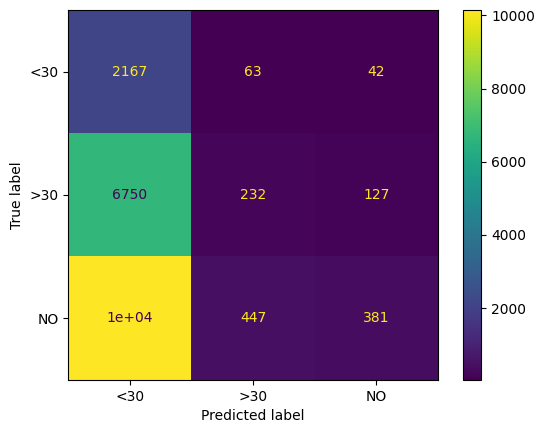

In [ ]:
from sklearn.metrics import f1_score, ConfusionMatrixDisplay

# predictions
'''
X_test in pipeline
preprocessor transforms test data
numeric features scaled using mean and std leared from X_train
categorical features one-hot encoded using categories learned from X_train
processed dense matrix sent to GuassianNB
GuassianNB predicts class for each row in X_test
'''
# outputs array of predicted classes
y_pred = pipeline.predict(X_test)

# one primary metric F1 score
f1 = f1_score(y_test, y_pred, average='weighted') # weighted because multiclass and not binary
                              # calcualtes F1 for each of 3 classes individually then weights averge
print("F1 score:", f1)

# one supporting artifact confusion matrix
# compares y_test truelabels vs y_pred predcited labels
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)